# Hello Quantum - Qiskit Edition
## Chapter 5: Bell Tests for Quantum and Classical Variables

If you don't know how to use Jupyter notebooks, see Chapter 1.

## Bell test for classical variables

Here we'll investigate how quantum variables (based on qubits) differ from standard ones (based on bits).

We'll do this by creating a pair of variables, which we will call `A` and `B`. We aren't going to put any conditions on what these can be, or how theu are initialized. So there are a lot of possibilities.

* Could be any kind of variable, such as
    * `int`
    * `list`
    * `dict`
    * ...
* Could be initialized by any kind of process, such as
    * left empty
    * filled with a given set of values
    * generated by a given random process
        * indepedently applied to `A` and `B`
        * applied to `A` and `B` together, allowing for correlations between their randomness

If the variables are initialized by a random process, it means they'll have different values every time we run our program. This is perfectly fine. The only rule we need to obey is that the process of generating the randomness is the same for every run.

We'll use the function below to set up these variables. This currently has `A` and `B` defined as to be partially correlated random floating point numbers. But you can change it to whatever you want.

In [1]:
import random
def setup_variables ():
    
    ### Replace this section with anything you want ###
    
    r = random.random()
    
    A = r*(2/3)
    B = r*(1/3)
    
    ### End of section ###
    
    return A, B

Our next job is to define a hashing function. This simply needs to take one of the variables as input, and then give a bit value as an output.

This function must also be capable of performing two different types of hash. So it needs to be able to be able to chew on a variable and spit out a bit in to different ways. Another input to the function is therefore the kind of hash we want to use.

To be consistent with the rest of the program, the two possible hash types should be called `'H'` and `'V'`. Also, the output must be in the form of a single value bit string: either `'0'` or `'1'`.

As an example, I created bits by comparing `A` and `B` to a certain value. The output is `'1'` if they are under that value, and `'0'` otherwise. The type of hash determines the value used.

In [2]:
def hash2bit ( variable, hash ):
    
    ### Replace this section with anything you want ###
    
    if hash=='V':
        bit = (variable<0.5)
    elif hash=='H':
        bit = (variable<0.25)
        
    bit = str(int(bit))
    
    ### End of section ###
        
    return bit

Once these are defined, there are four quantities we wish to calculate: `P['HH']`, `P['HV']`, `P['VH']` and `P['VV']`.

Let's focus on `P['HV']` as an example. This is the probability that the bit value derived from an `'H'` type hash on `A` is the same as that from a `'V'` type has on `B`. We will estimate this probability by sampling many times and determining the fraction of samples for which the corresponding bit values agree.

The other probabilities are defined similarly: `P['HH']` compares a `'H'` type hash on both `A` and `B`, `P['VV']` compares a `V` type hash on both, and `P['VH']` compares a `V` type hash on `A` with a `H` type has on `B`.

These probabilities are calculated in the following function, which returns all the values of `P` in a dictionary. The parameter `shots` is the number of samples we'll use.

In [3]:
shots = 8192
def calculate_P ( ):
    
    P = {}
    for hashes in ['VV','VH','HV','HH']:
        
        # calculate each P[hashes] by sampling over `shots` samples
        P[hashes] = 0
        for shot in range(shots):

            A, B = setup_variables()

            a = hash2bit ( A, hashes[0] ) # hash type for variable `A` is the first character of `hashes`
            b = hash2bit ( B, hashes[1] ) # hash type for variable `B` is the second character of `hashes`

            P[hashes] += (a!=b) / shots
 
    return P

Now let's actually calculate these values for the method we have chosen to set up and hash the variables.

In [4]:
P = calculate_P()
print(P)

{'VV': 0.250244140625, 'VH': 0.0, 'HV': 0.6279296875, 'HH': 0.3765869140625}


These values will vary slightly from one run to the next due to the fact that we only use a finite number of shots. To change them significantly, we need to change the way the variables are initiated, and/or the way the hash functions are defined.

No matter how these functions are defined, there are certain restrictions that the values of `P` will always obey.

For example, consider the case that `P['HV']`, `P['VH']` and `P['VV']` are all `0.0`. The only way that this can be possible is for `P['HH']` to also be `0.0`.

To see why, we start by noting that `P['HV']=0.0` is telling us that `hash2bit ( A, H )` and `hash2bit ( B, V )` were never different in any of the runs. So this means we can always expect them to be equal.

    hash2bit ( A, H ) = hash2bit ( B, V )        (1)
    
From `P['VV']=0.0` and `P['VH']=0.0` we can similarly get

    hash2bit ( A, V ) = hash2bit ( B, V )        (2)
    
    hash2bit ( A, V ) = hash2bit ( B, H )        (3)
    
Putting (1) and (2) together implies that

    hash2bit ( A, H ) = hash2bit ( A, V )        (4)
    
Combining this with (3) gives

    hash2bit ( A, H ) = hash2bit ( B, H )        (5)

And if these values are always equal, we'll never see a run in which they are different. This is exactly what we set out to prove: `P['HH']=0.0`.

More generally, we can use the values of `P['HV']`, `P['VH']` and `P['VV']` to set an upper limit on what `P['HH']` can be. By adapting the [CHSH inequality](https://en.wikipedia.org/wiki/CHSH_inequality) we find that

$\,\,\,\,\,\,\,$ `P['HH']` $\, \leq \,$ `P['HV'] + P['VH'] + P['VV']`

This is not just a special property of `P['HH']`. It's also true for all the others: each of these probabilities cannot be greater than the sum of the others.

To test whether this logic holds, we'll see how well the probabilities obey these inequalities. Note that we might get slight violations due to the fact that our the `P` values aren't exact, but are estimations made using a limited number of samples.

In [5]:
def bell_test (P):
    
    sum_P = sum(P.values())
    for hashes in P:
        
        bound = sum_P - P[hashes]
        
        print("The upper bound for P['"+hashes+"'] is "+str(bound))
        print("The value of P['"+hashes+"'] is "+str(P[hashes]))
        if P[hashes]<=bound:
            print("The upper bound is obeyed :)\n")
        else:
            if P[hashes]-bound < 0.1:
                print("This seems to have gone over the upper bound, but only by a little bit :S\nProbably just rounding errors or statistical noise.\n")
            else:
                print("!!!!! This has gone well over the upper bound :O !!!!!\n")

In [6]:
bell_test(P)

The upper bound for P['VV'] is 1.0045166015625
The value of P['VV'] is 0.250244140625
The upper bound is obeyed :)

The upper bound for P['VH'] is 1.2547607421875
The value of P['VH'] is 0.0
The upper bound is obeyed :)

The upper bound for P['HV'] is 0.6268310546875
The value of P['HV'] is 0.6279296875
This seems to have gone over the upper bound, but only by a little bit :S
Probably just rounding errors or statistical noise.

The upper bound for P['HH'] is 0.878173828125
The value of P['HH'] is 0.3765869140625
The upper bound is obeyed :)



With the initialization and hash functions provided in this notebook, the value of `P('HV')` should be pretty much the same as the upper bound. Since the numbers are estimated statistically, and therefore are slightly approximate due to statistical noise, you might even see it go a tiny bit over. But you'll never see it significantly surpass the bound.

If you don't beleive me, try it for yourself. Change the way the variables are initialized, and how the hashes are calculated, and try to get one of the bounds to be significantly broken.

## Bell test for quantum variables

Now we are going to do the same thing all over again, except our variables `A` and `B` will be quantum variables. Specifically, they'll be the simplest kind of quantum variable: qubits.

Since you probably don't have a quantum computer handy, you can borrow from IBM.

In [7]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, execute
from qiskit import register, available_backends, get_backend

When writing quantum programs, we have to set up our qubits and bits before we can use them. This is done by the function below. It defines a register of two bits, and assigns them as our variables `A` and `B`. It then sets up a register of two bits to receive the outputs, and assigns them as `a` and `b`.

Finally it uses these registers to set up an empty quantum program. This is called `qc`.

In [8]:
def initialize_program ():
    
    qubit = QuantumRegister(2)
    A = qubit[0]
    B = qubit[1]
    
    bit = ClassicalRegister(2)
    a = bit[0]
    b = bit[1]
    
    qc = QuantumCircuit(qubit, bit)
    
    return A, B, a, b, qc

Before we start writing the quantum program to set up our variables, let's think about what needs to happen at the end of the program. This will be where we define the different hash functions, which turn our qubits into bits.

The simplest way to extract a bit from a qubit is through the `measure` command. This corresponds to the bottom circle of a qubit in the visualization we've been using. Let's use this as our `V` type hash.

For the output that corresponds to the top circle, there is no direct means of access. However, we can do it indirectly by first doing an `h` to swap the top and bottom circles, and then using the `measure` command. This will be our `H` type hash.

Note that this function has more inputs that its classical counterpart. We have to tell it the `bit` on which to write the result, and the quantum program, `qc`, on which we write the commands.

In [9]:
def hash2bit  ( variable, hash, bit, qc ):
    
    if hash=='H':
        qc.h( variable )
        
    qc.measure( variable, bit )
        

Now its time to set up the variables `A` and `B`. To write this program, you can use the grid below. You can either follow the suggested exercise, or do whatever you like. Once you are ready, just move on. The cell containing the `setup_variables()` function, will then use the program you wrote with the grid.

Note that our choice of means that the probabilities `P['HH']`, `P['HV']`, `P['VH']` and `P['VV']` will explicitly correspond to circles on our grid. For example, the circle at the very top tells us how likely the two top outputs would be to disagree. If this is white, then `P['HH']=1` , if it is black then `P['HH']=0`.

### Exercise
* Make it so thatoutputs from the bottom circles of both qubits are most likely to disagree, whereas all other combinations of outputs are most likely to agree.

<IPython.core.display.Javascript object>


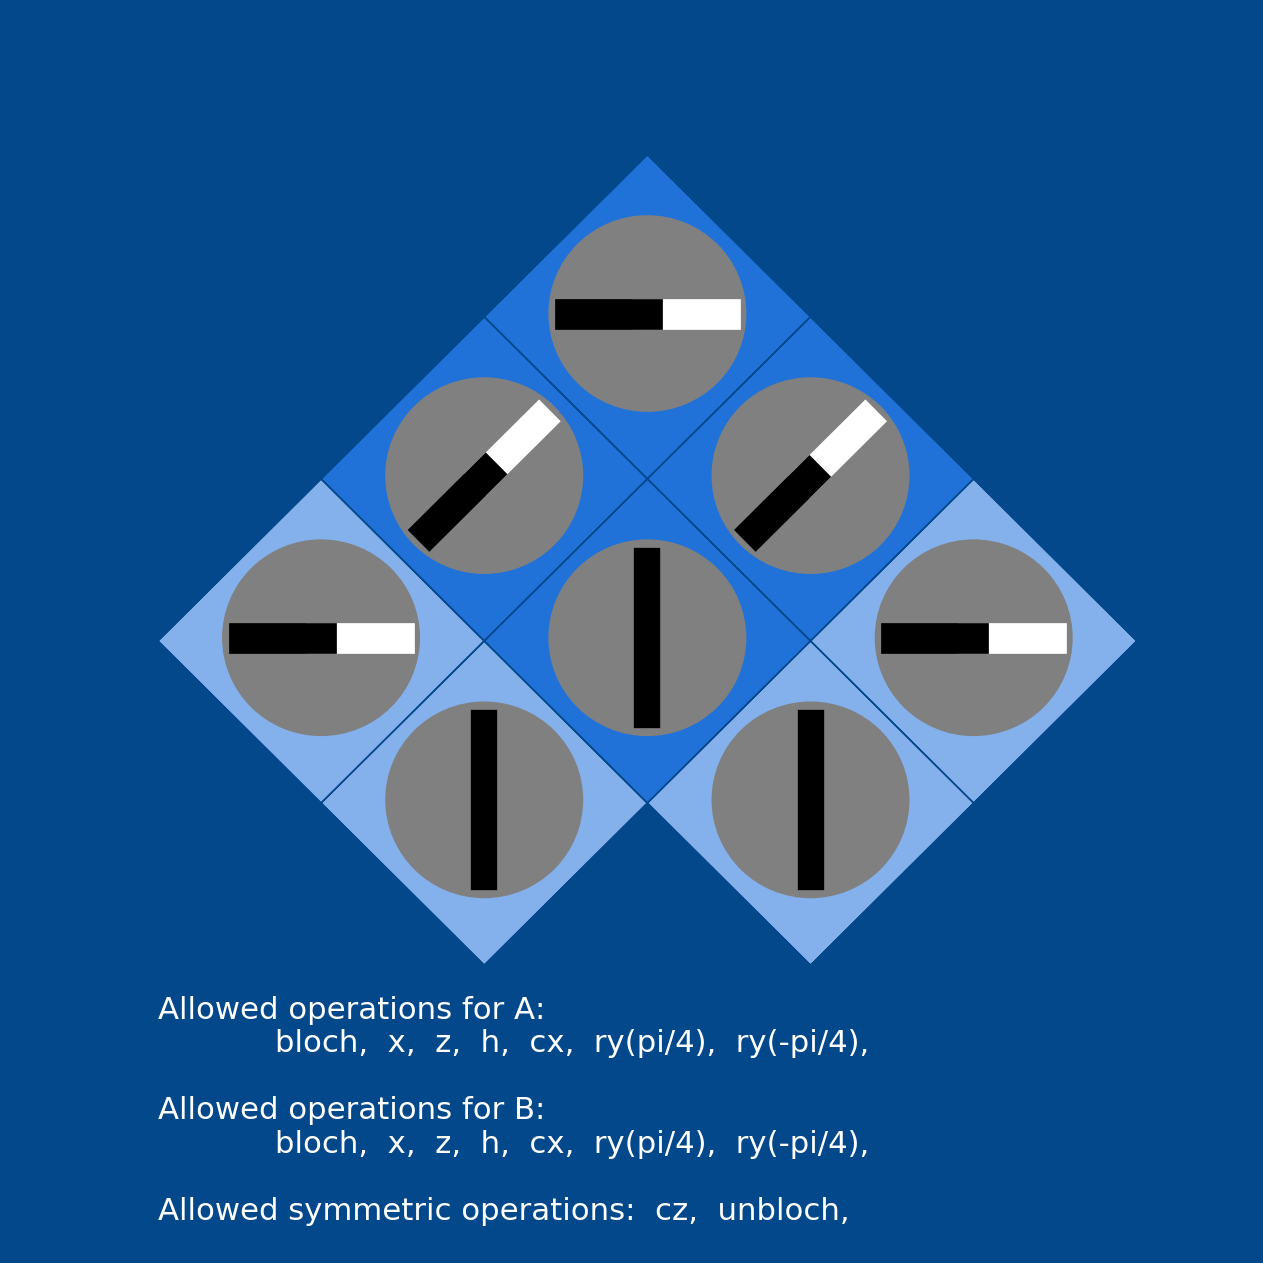


Your quantum program so far

qc.cx(B,A)
qc.cz(A,B)


In [1]:
%matplotlib notebook
import engine
initialize = []
success_condition = {'ZZ':-0.7071,'ZX':-0.7071,'XZ':-0.7071,'XX':-0.7071}
allowed_gates = {'0': {'bloch':0, 'x':0, 'z':0, 'h':0, 'cx':0, 'ry(pi/4)': 0, 'ry(-pi/4)': 0}, '1': {'bloch':0, 'x':0, 'z':0, 'h':0, 'cx':0, 'ry(pi/4)': 0, 'ry(-pi/4)': 0}, 'both': {'cz':0, 'unbloch':0}}
vi = [[], True, True]
qubit_names = {'0':'A', '1':'B'}
writer = engine.run_game(initialize, success_condition, allowed_gates, vi, qubit_names, mode='line')

In [11]:
import numpy as np
def setup_variables ( A, B, qc ):
        
    for line in writer.program:
        eval(line)


The values of `P` are calculated in the function below. This is done by sending jobs to IBM and getting results which tell us how many of the samples gave each possible result. The results are given as a bit string, `string`, which IBM numbers from right to left. This means that the value of `a`, which corresponds to `bit[0]` is the first from the right

    a = string[-1]
    
and the value of `b` is right next to it at the second from the right

    b = string[-2]

The number of samples for this bit string is provided by the dictionary of results, `stats`, as `stats[string]`.

In [12]:
shots = 8192
def calculate_P ( backend ):
    
    P = {}
    program = {}
    for hashes in ['VV','VH','HV','HH']:

        A, B, a, b, program[hashes] = initialize_program ()

        setup_variables( A, B, program[hashes] )

        hash2bit ( A, hashes[0], a, program[hashes])
        hash2bit ( B, hashes[1], b, program[hashes])
            
    # submit jobs
    job = execute( list(program.values()), backend, shots=shots )

    # get the results
    for hashes in ['VV','VH','HV','HH']:
        stats = job.result().get_counts(program[hashes])
        
        P[hashes] = 0
        for string in stats.keys():
            a = string[-1]
            b = string[-2]
            
            if a!=b:
                P[hashes] += stats[string] / shots

    return P

Now its time to choose and set up the actually device we are going to use. By default, we'll use a simulator. But if you want to use the real device, just replace the first line below with `device='ibmqx4'`.

In [13]:
device = 'local_qasm_simulator'
backend = get_backend(device)
print(backend.status)

{'name': 'local_qasm_simulator_py', 'operational': True, 'pending_jobs': 0}


In [14]:
P = calculate_P( backend )
print(P)

{'VV': 0, 'VH': 0.5032958984375, 'HV': 0.4937744140625, 'HH': 0.4984130859375}


In [15]:
bell_test( P )

The upper bound for P['VV'] is 1.4954833984375
The value of P['VV'] is 0
The upper bound is obeyed :)

The upper bound for P['VH'] is 0.9921875
The value of P['VH'] is 0.5032958984375
The upper bound is obeyed :)

The upper bound for P['HV'] is 1.001708984375
The value of P['HV'] is 0.4937744140625
The upper bound is obeyed :)

The upper bound for P['HH'] is 0.9970703125
The value of P['HH'] is 0.4984130859375
The upper bound is obeyed :)



If you prepared the state suggestion by the exercise, you will have found a significant violation of the upper bound for `P['HH']`. So what is going on here? The chain of logic we based the Bell test on obviously doesn't apply to quantum variables. But why?

The answer is that there is a hidden assumption in that logic. To see why, let's revisit point (4).

    hash2bit ( A, H ) = hash2bit ( A, V )        (4)
    
Here we compare the value we'd get from an `H` type of hash of the variable `A` with that for a `V` type hash.

For classical variables, this is perfectly sensible. There is nothing stopping us from calculating both hashes and comparing the results. Even if calculating the hash of a variable changes the variable, that's not a problem. All we need to do is copy it beforehand and we can do both hashes without any issue.

The same is not true for quantum variables. The result of the hashes is not known until we actually do them. It's only then that the qubit actually decides what bit value to give. And once it decides the value for one type of hash, we can never determine what it would have decided if we had used another type of hash. We can't get around this by copying the quantum variables either, because quantum variables [cannot be copied](https://en.wikipedia.org/wiki/No-cloning_theorem). This means there is no context in which the values `hash2bit(A,H)` and `hash2bit(A,V)` are well-defined at the same time, and so it is impossible to compare them.

Another hidden assumption is that `hash2bit(A,hash)` depends only on the type of hash chosen for variable `A`, and not the one chosen for variable `B`. This is also perfectly sensible, since this exactly the way we set up the `hash2bit()` function. However, the very fact that the upper bound was violated does seem to imply that each variable knows what hash is  being done to the other, so they they can conspire to give very different behaviour when both have a `H` type hash.

Even so, the effect is subtle. It is impossible to determine which variable is affecting which: You can change the order in which the hashes are done, or [effectively do them at the same time](https://en.wikipedia.org/wiki/Loopholes_in_Bell_test_experiments#Communication,_or_locality), and you'll get the same results. This means that it not clear whether we can say they affect each other (see [here](https://quantumcomputing.stackexchange.com/questions/2028/is-it-true-to-say-that-one-qubit-in-an-entangled-state-can-instantaneously-affec) for some discussion). But what we can say is that they are [contextual](https://en.wikipedia.org/wiki/Quantum_contextuality): to fully understand results from one variable, it is sometimes required to look at what was done to another.

All this goes to show that quantum variables don't always follow the logic we are used to. They follow different rules, the rules of quantum mechanics, which will allow us to find ways of performing computation in very different ways than we are used to.

To get more examples of this kind of effect, see [this notebook](https://github.com/QISKit/qiskit-tutorial/blob/master/reference/qis/entanglement_revisited.ipynb) in the QISKit tutorial.